In [8]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from pathlib import Path

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Dataset 3

In [13]:
WORK_DIR = Path("/content")
DATA_ROOT = WORK_DIR / "nih_resized"
DATA_DIR  = DATA_ROOT / "images-224" / "images-224"
ZIP_NAME  = "nih-chest-x-ray-14-224x224-resized.zip"
KAGGLE_DATASET = "khanfashee/nih-chest-x-ray-14-224x224-resized"
CSV_PATH  = DATA_ROOT / "Data_Entry_2017.csv"

# Onde salvar modelos
BASE_MODELS = "/content/drive/MyDrive/TCC/models"
os.makedirs(BASE_MODELS, exist_ok=True)

In [14]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
MANTER_PROPORCAO = True

In [15]:
import subprocess
import sys

def carregarDatasetKaggle(kaggle_dataset, zip_name, data_root, data_dir, kaggle_json_path=None):
    data_root = Path(data_root)
    data_dir  = Path(data_dir)
    work_dir  = Path("/content")
    print("Work dir:", work_dir)
    print("Data root:", data_root)
    print("Data dir esperado:", data_dir)

    # 1) Garante pacote kaggle
    try:
        import kaggle  # noqa
    except Exception:
        print("Instalando pacote kaggle...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "kaggle"], check=True)

    # 2) Configura credencial kaggle.json
    kaggle_dir = Path.home() / ".kaggle"
    kaggle_dir.mkdir(parents=True, exist_ok=True)
    cred_file = kaggle_dir / "kaggle.json"

    if kaggle_json_path:
        kaggle_json_path = Path(kaggle_json_path)
        if not kaggle_json_path.exists():
            raise FileNotFoundError(f"kaggle.json não encontrado em: {kaggle_json_path}")
        cred_file.write_bytes(kaggle_json_path.read_bytes())
        print("kaggle.json copiado de:", kaggle_json_path)
    else:
        u = os.environ.get("KAGGLE_USERNAME")
        k = os.environ.get("KAGGLE_KEY")
        if u and k:
            cred_file.write_text(json.dumps({"username": u, "key": k}))
            print("kaggle.json criado a partir de variáveis de ambiente.")
        elif not cred_file.exists():
            raise RuntimeError(
                "Credenciais do Kaggle ausentes. Forneça kaggle_json_path ou exporte "
                "KAGGLE_USERNAME e KAGGLE_KEY."
            )
    os.chmod(cred_file, 0o600)

    # 3) Baixa o zip se necessário
    data_root.mkdir(parents=True, exist_ok=True)
    zip_path = data_root / zip_name

    if data_dir.exists() and any(data_dir.iterdir()):
        print("Dataset já parece extraído em", data_dir)
        return

    if not zip_path.exists():
        print(f"Baixando dataset {kaggle_dataset} do Kaggle...")
        cmd = ["kaggle", "datasets", "download", "-d", kaggle_dataset, "-p", str(data_root), "--force"]
        proc = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
        print(proc.stdout)
        if proc.returncode != 0:
            raise RuntimeError("Falha no download via Kaggle. Verifique credenciais e dataset id.")

    # 4) Descompacta
    if not data_dir.exists() or not any(data_dir.iterdir()):
        print("Descompactando...")
        proc = subprocess.run(["unzip", "-q", str(zip_path), "-d", str(data_root)])
        if proc.returncode != 0:
            raise RuntimeError(f"Falha ao descompactar: {zip_path}")
        print("Extração concluída.")

    # 5) Verifica conteúdo final
    if not data_dir.exists() or not any(data_dir.iterdir()):
        raise RuntimeError(f"Após extração, {data_dir} ainda está vazio. Confira estrutura do zip.")
    print("OK! Dados prontos em:", data_dir)

# Executa download/extração (ajuste o caminho do seu kaggle.json se necessário)
carregarDatasetKaggle(
    kaggle_dataset=KAGGLE_DATASET,
    zip_name=ZIP_NAME,
    data_root=DATA_ROOT,
    data_dir=DATA_DIR,
    kaggle_json_path="/content/kaggle.json"
)


Work dir: /content
Data root: /content/nih_resized
Data dir esperado: /content/nih_resized/images-224/images-224
Instalando pacote kaggle...
kaggle.json copiado de: /content/kaggle.json
Baixando dataset khanfashee/nih-chest-x-ray-14-224x224-resized do Kaggle...
Dataset URL: https://www.kaggle.com/datasets/khanfashee/nih-chest-x-ray-14-224x224-resized
License(s): CC0-1.0

  0%|          | 0.00/2.30G [00:00<?, ?B/s]
  7%|▋         | 157M/2.30G [00:00<00:01, 1.65GB/s]
 14%|█▎        | 319M/2.30G [00:00<00:01, 1.67GB/s]
 20%|██        | 482M/2.30G [00:00<00:01, 1.69GB/s]
 27%|██▋       | 643M/2.30G [00:00<00:01, 1.63GB/s]
 34%|███▍      | 799M/2.30G [00:00<00:01, 1.27GB/s]
 39%|███▉      | 930M/2.30G [00:00<00:01, 1.06GB/s]
 44%|████▍     | 1.02G/2.30G [00:00<00:01, 1.05GB/s]
 49%|████▉     | 1.12G/2.30G [00:00<00:01, 1.04GB/s]
 53%|█████▎    | 1.22G/2.30G [00:01<00:01, 1.03GB/s]
 57%|█████▋    | 1.32G/2.30G [00:01<00:01, 804MB/s] 
 61%|██████    | 1.40G/2.30G [00:01<00:01, 609MB/s]
 64%|█

In [16]:
def LerCSVNIHGenero(csv_path: str, img_dir: str):
    df = pd.read_csv(csv_path)

    possiveis_cols = ["gender", "Gender", "Patient Gender", "patient_gender", "Patient Gender "]
    col_gender = next((c for c in possiveis_cols if c in df.columns), None)
    if col_gender is None:
        raise ValueError(f"Não encontrei coluna de gênero. Colunas disponíveis: {list(df.columns)}")

    def NormalizarGenero(x):
        s = str(x).strip().lower()
        if s in {"m", "male"}: return "male"
        if s in {"f", "female"}: return "female"
        return s

    if "Image Index" in df.columns:
        df = df.rename(columns={"Image Index": "imageId"})
    elif "imageId" not in df.columns:
        raise ValueError("Não encontrei coluna de arquivo de imagem ('Image Index' ou 'imageId').")

    df["imageId"] = df["imageId"].astype(str)
    df["gender"]  = df[col_gender].apply(NormalizarGenero)

    # Mantém só imagens existentes
    df["__exists__"] = df["imageId"].apply(lambda f: os.path.exists(os.path.join(img_dir, f)))
    df = df[df["__exists__"]].drop(columns="__exists__").reset_index(drop=True)

    return df[["imageId", "gender"]]

# Lê e prepara
df3 = LerCSVNIHGenero(str(CSV_PATH), str(DATA_DIR))

# AE é não supervisionado -> remove 'gender'
df3 = df3.drop(columns=["gender"]).sample(frac=1, random_state=12).reset_index(drop=True)

print(f"Total de imagens disponíveis: {len(df3)}")


Total de imagens disponíveis: 112120


In [17]:
# DIVISÃO FIXA: 3000 / 2000 / 2000
if len(df3) < 7000:
    raise ValueError(f"O dataset tem apenas {len(df3)} imagens; são necessárias pelo menos 7000.")

train_df3 = df3.iloc[:3000]
val_df3   = df3.iloc[3000:5000]
test_df3  = df3.iloc[5000:7000]

print(f"Tamanhos finais -> Train: {len(train_df3)}, Val: {len(val_df3)}, Test: {len(test_df3)}")


Tamanhos finais -> Train: 3000, Val: 2000, Test: 2000


In [18]:
# 'train_dir' como TENSOR para tf.strings.join
train_dir = tf.constant(str(DATA_DIR))

def CarregarEPreprocessar(filename):
    # 'filename' é algo como "000123.png"
    img_path = tf.strings.join([train_dir, filename], separator='/')
    image_bytes = tf.io.read_file(img_path)
    # PNG garantido neste dataset; se houver JPG, use decode_image
    image = tf.image.decode_png(image_bytes, channels=1)  # troque para 3 se RGB
    image = tf.image.convert_image_dtype(image, tf.float32)

    if MANTER_PROPORCAO:
        image = tf.image.resize_with_pad(image, IMG_SIZE[0], IMG_SIZE[1])
    else:
        image = tf.image.resize(image, IMG_SIZE)

    return image, image  # AE: (entrada, alvo)

def criar_dataset(file_list):
    ds = tf.data.Dataset.from_tensor_slices(file_list.astype(str))
    ds = ds.map(CarregarEPreprocessar, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# Construção dos datasets
train_dataset = criar_dataset(train_df3["imageId"].values)
val_dataset   = criar_dataset(val_df3["imageId"].values)
test_dataset  = criar_dataset(test_df3["imageId"].values)


###AutoEncoder3

In [ ]:
autoencoder = models.Sequential(name="AutoencoderD3")

# ENCODER (4 camadas)

autoencoder.add(layers.Input(shape=(224, 224, 1)))
autoencoder.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(layers.MaxPooling2D((2, 2), padding='same'))   # 224 → 112

autoencoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(layers.MaxPooling2D((2, 2), padding='same'))   # 112 → 56

autoencoder.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))
autoencoder.add(layers.MaxPooling2D((2, 2), padding='same'))   # 56 → 28

autoencoder.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(layers.MaxPooling2D((2, 2), padding='same', name="encoder_out"))  # 28 → 14

# DECODER (3 camadas)
autoencoder.add(layers.Conv2DTranspose(96, (3, 3), strides=2, activation='relu', padding='same'))   # 14 → 28
autoencoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'))   # 28 → 56
autoencoder.add(layers.Conv2DTranspose(32, (3, 3), strides=4, activation='relu', padding='same'))   # 56 → 224
autoencoder.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))                     # saída final

# Compilação
autoencoder.compile(optimizer=optimizers.Adam(1e-3), loss='mse')
autoencoder.summary()

Model: "AutoencoderD3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_out (MaxPooling2D)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 96)     │       110,688 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 56, 56, 64)     │        55,360 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 224, 224, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,729 (1.41 MB)

 Trainable params: 369,729 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
log_dir = "/content/drive/MyDrive/TCC/logs"
os.makedirs(log_dir, exist_ok=True)
log_path = os.path.join(log_dir, "treino_autoencoder3.csv")
csv_logger = CSVLogger(log_path, append=False)

history = autoencoder.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[csv_logger],
    verbose=1
)

Epoch 1/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 103ms/step - loss: 0.0485 - val_loss: 0.0057
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 12/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0

In [ ]:
#Extração do encoder

# força o build (evita erro de 'no defined input')
_ = autoencoder(tf.zeros((1, 224, 224, 1)))

# recorte pelo índice correto (7) ou pelo nome da camada
encoder_output = autoencoder.layers[7].output
# alternativa robusta: encoder_output = autoencoder.get_layer("encoder_out").output

encoder = tf.keras.Model(
    inputs=autoencoder.layers[0].input,
    outputs=encoder_output,
    name="Encoder"
)
encoder.summary()


Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_out (MaxPooling2D)      │ (None, 14, 14, 128)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,928 (722.38 KB)

 Trainable params: 184,928 (722.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Feature model (encoder + GAP)
gap = tf.keras.layers.GlobalAveragePooling2D(name="gap")(encoder.output)
feature_model = tf.keras.Model(inputs=encoder.input, outputs=gap, name="FeatureModel")
feature_model.summary()

Model: "FeatureModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_out (MaxPooling2D)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,928 (722.38 KB)

 Trainable params: 184,928 (722.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
BASE_MODELS = "/content/drive/MyDrive/TCC/models"

# Função para salvar os modelos
def SalvarModelos(encoder, nome_base, pasta=BASE_MODELS, feature_model=None, autoencoder=None):
    os.makedirs(pasta, exist_ok=True)
    caminhos = {}

    caminho_encoder = os.path.join(pasta, f"{nome_base}_encoder.keras")
    encoder.save(caminho_encoder)
    caminhos["encoder"] = caminho_encoder

    if feature_model is not None:
        caminho_feature = os.path.join(pasta, f"{nome_base}_feature.keras")
        feature_model.save(caminho_feature)
        caminhos["feature_model"] = caminho_feature

    if autoencoder is not None:
        caminho_auto = os.path.join(pasta, f"{nome_base}_autoencoder.keras")
        autoencoder.save(caminho_auto)
        caminhos["autoencoder"] = caminho_auto

    return caminhos

In [ ]:
#Salvar Modelos
paths = SalvarModelos(encoder, nome_base="AE_D3", feature_model=feature_model, autoencoder=autoencoder)
print(paths)

{'encoder': '/content/drive/MyDrive/TCC/models/AE_D3_encoder.keras', 'feature_model': '/content/drive/MyDrive/TCC/models/AE_D3_feature.keras', 'autoencoder': '/content/drive/MyDrive/TCC/models/AE_D3_autoencoder.keras'}


### SVM Encoder 3 ➜ Dataset 3

####Dataset 3

In [19]:
WORK_DIR = Path("/content")
DATA_ROOT = WORK_DIR / "nih_resized"
DATA_DIR  = DATA_ROOT / "images-224" / "images-224"
ZIP_NAME  = "nih-chest-x-ray-14-224x224-resized.zip"
KAGGLE_DATASET = "khanfashee/nih-chest-x-ray-14-224x224-resized"
CSV_PATH  = DATA_ROOT / "Data_Entry_2017.csv"

BASE_MODELS = "/content/drive/MyDrive/TCC/models"

# CONSTANTES
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
MANTER_PROPORCAO = True

In [20]:
carregarDatasetKaggle(
    kaggle_dataset=KAGGLE_DATASET,
    zip_name=ZIP_NAME,
    data_root=DATA_ROOT,
    data_dir=DATA_DIR,
    kaggle_json_path="/content/kaggle.json"
)

Work dir: /content
Data root: /content/nih_resized
Data dir esperado: /content/nih_resized/images-224/images-224
Instalando pacote kaggle...
kaggle.json copiado de: /content/kaggle.json
Dataset já parece extraído em /content/nih_resized/images-224/images-224


In [21]:
def Split_70_15_15Genero(df: pd.DataFrame, seed: int = 12):
    vc = df["gender"].value_counts()
    if (vc < 2).any() or len(vc) < 2:
        rng = np.random.RandomState(seed)
        tr, va, te = [], [], []
        for _, grp in df.groupby("gender"):
            n = len(grp)
            if n == 1: tr.append(grp); continue
            n_val  = max(1, int(round(0.15 * n)))
            n_test = max(1, int(round(0.15 * n)))
            if n_val + n_test >= n: n_val, n_test = 1, 1
            grp = grp.sample(frac=1.0, random_state=rng.randint(0,10**6)).reset_index(drop=True)
            va.append(grp.iloc[:n_val])
            te.append(grp.iloc[n_val:n_val+n_test])
            tr.append(grp.iloc[n_val+n_test:])
        df_train = pd.concat(tr, ignore_index=True).sample(frac=1.0, random_state=seed).reset_index(drop=True)
        df_val   = pd.concat(va, ignore_index=True).sample(frac=1.0, random_state=seed).reset_index(drop=True)
        df_test  = pd.concat(te, ignore_index=True).sample(frac=1.0, random_state=seed).reset_index(drop=True)
        return df_train, df_val, df_test

    df_train, df_tmp = train_test_split(df, test_size=0.30, stratify=df["gender"], random_state=seed)
    df_val, df_test  = train_test_split(df_tmp, test_size=0.50, stratify=df_tmp["gender"], random_state=seed)
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)

df3 = LerCSVNIHGenero(str(CSV_PATH), str(DATA_DIR))
df3_train, df3_val, df3_test = Split_70_15_15Genero(df3, seed=12)
print(len(df3_train), len(df3_val), len(df3_test))

78484 16818 16818


In [22]:
def amostrar_estratificado(df, n_total, label_col="gender", seed=12):
    import numpy as np
    rng = np.random.RandomState(seed)
    n_total = min(n_total, len(df))
    partes = []
    for cls, g in df.groupby(label_col):
        prop = len(g) / len(df)
        n_cls = max(1, int(round(prop * n_total)))
        partes.append(g.sample(n=min(n_cls, len(g)), random_state=rng.randint(0, 10**6)))
    sub = pd.concat(partes).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    if len(sub) > n_total:
        sub = sub.iloc[:n_total].reset_index(drop=True)
    return sub

# Tamanhos solicitados
df3_train_small = amostrar_estratificado(df3_train, 2000, label_col="gender", seed=12)
df3_val_small   = amostrar_estratificado(df3_val,   1000, label_col="gender", seed=12)
df3_test_small  = amostrar_estratificado(df3_test,  1000, label_col="gender", seed=12)

print("Reduzidos ->", len(df3_train_small), len(df3_val_small), len(df3_test_small))

Reduzidos -> 2000 1000 1000


In [23]:
# Necessário para CarregarEPreprocessar
train_dir = tf.constant(str(DATA_DIR))

def CarregarEPreprocessar(filename):
    img_path = tf.strings.join([train_dir, filename], separator='/')
    b = tf.io.read_file(img_path)
    img = tf.image.decode_png(b, channels=1)  # mude para 3 se seu AE3 foi treinado em RGB
    img = tf.image.convert_image_dtype(img, tf.float32)
    if MANTER_PROPORCAO:
        img = tf.image.resize_with_pad(img, IMG_SIZE[0], IMG_SIZE[1])
    else:
        img = tf.image.resize(img, IMG_SIZE)
    return img, img  # (x,y) — vamos mapear para só x abaixo

def DatasetSoImagens(ids_series: pd.Series):
    ds = tf.data.Dataset.from_tensor_slices(ids_series.astype(str).values)
    ds = ds.map(CarregarEPreprocessar, num_parallel_calls=AUTOTUNE)  # (img, img)
    ds = ds.map(lambda x, y: x)  # só imagem para o feature_model
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

d3_train_ds = DatasetSoImagens(df3_train_small["imageId"])
d3_val_ds   = DatasetSoImagens(df3_val_small["imageId"])
d3_test_ds  = DatasetSoImagens(df3_test_small["imageId"])


In [24]:
feature_model = load_model(f"{BASE_MODELS}/AE_D3_feature.keras", compile=False)
feature_model.summary()

Model: "FeatureModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_out (MaxPooling2D)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,928 (722.38 KB)

 Trainable params: 184,928 (722.38 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Embeddings
X_tr = feature_model.predict(d3_train_ds, verbose=0)
X_va = feature_model.predict(d3_val_ds,   verbose=0)
X_te = feature_model.predict(d3_test_ds,  verbose=0)

# Rótulos (conjuntos reduzidos)
y_tr = df3_train_small["gender"].values
y_va = df3_val_small["gender"].values
y_te = df3_test_small["gender"].values

print("Embeddings shapes (tr/va/te):", X_tr.shape, X_va.shape, X_te.shape)


Embeddings shapes (tr/va/te): (2000, 128) (1000, 128) (1000, 128)


In [26]:
def FormatarSaida(x: float) -> str:
    return f"{x*100:.2f}%".replace('.', ',')

scaler = StandardScaler()
Xtr = normalize(scaler.fit_transform(X_tr))
Xva = normalize(scaler.transform(X_va))
Xte = normalize(scaler.transform(X_te))

svm = SVC(kernel='linear', class_weight='balanced', random_state=12)
svm.fit(Xtr, y_tr)

y_va_pred = svm.predict(Xva)
y_te_pred = svm.predict(Xte)

AVG = 'weighted'
print("Val  Acc:", FormatarSaida(accuracy_score(y_va, y_va_pred)))
print("Val   F1:", FormatarSaida(f1_score(y_va, y_va_pred, average=AVG)))
print("Test Acc:", FormatarSaida(accuracy_score(y_te, y_te_pred)))
print("Test  F1:", FormatarSaida(f1_score(y_te, y_te_pred, average=AVG)))


Val  Acc: 64,30%
Val   F1: 64,30%
Test Acc: 63,10%
Test  F1: 63,05%


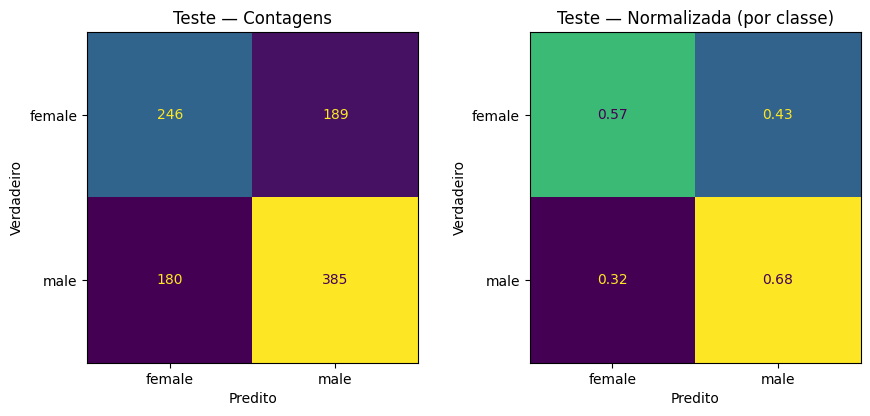


=== Classification report (Teste) ===
              precision    recall  f1-score   support

      female       0.58      0.57      0.57       435
        male       0.67      0.68      0.68       565

    accuracy                           0.63      1000
   macro avg       0.62      0.62      0.62      1000
weighted avg       0.63      0.63      0.63      1000



In [27]:
#plotar matriz de confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Se quiser ordem automática a partir dos dados de teste:
CLASSES = np.unique(np.concatenate([y_te, y_te_pred]))
# (Opcional) ordem fixa:
# CLASSES = np.array(["female","male"])

cm_test      = confusion_matrix(y_te, y_te_pred, labels=CLASSES)
cm_test_norm = confusion_matrix(y_te, y_te_pred, labels=CLASSES, normalize="true")

fig, axes = plt.subplots(1, 2, figsize=(9, 4.2))

disp_cnt = ConfusionMatrixDisplay(cm_test, display_labels=CLASSES)
disp_cnt.plot(ax=axes[0], values_format="d", colorbar=False)
axes[0].set_title("Teste — Contagens")
axes[0].set_xlabel("Predito"); axes[0].set_ylabel("Verdadeiro")

disp_norm = ConfusionMatrixDisplay(cm_test_norm, display_labels=CLASSES)
disp_norm.plot(ax=axes[1], values_format=".2f", colorbar=False)
axes[1].set_title("Teste — Normalizada (por classe)")
axes[1].set_xlabel("Predito"); axes[1].set_ylabel("Verdadeiro")

plt.tight_layout()

out_dir = Path("/content/drive/MyDrive/TCC/outputs")   # troque pela pasta que quiser
out_dir.mkdir(parents=True, exist_ok=True)
fname = "matriz_confusao_D3_test.png"                   # troque o nome se quiser
fig.savefig(out_dir / fname, dpi=180, bbox_inches="tight")

plt.show()

print("\n=== Classification report (Teste) ===")
print(classification_report(y_te, y_te_pred, target_names=[str(c) for c in CLASSES]))

### SVM Encoder 3 ➜ Dataset 2

In [ ]:
D2_BASE = "/content/drive/MyDrive/TCC/D2"
D2_IMG_DIR = os.path.join(D2_BASE, "image")
D2_CSV = os.path.join(D2_BASE, "MetaData.csv")

# 1) Carrega o feature_model do AE1 (encoder + GAP)
feature_model = load_model(f"{BASE_MODELS}/AE_D3_feature.keras", compile=False)

In [ ]:
# 2) Lê D2 e prepara splits 70/15/15 por 'gender'
df2 = pd.read_csv(D2_CSV)
df2["imageId"] = df2["id"].astype(int).astype(str) + ".png"

In [ ]:
def split_70_15_15_por_classe(df, label_col="gender", rnd=12):
    rng = np.random.RandomState(rnd)
    partes_train, partes_val, partes_test = [], [], []
    for cls, g in df.groupby(label_col):
        n = len(g)
        if n == 1:
            partes_train.append(g)  # 1 amostra -> treino
            continue
        n_val  = max(1, int(round(0.15 * n)))
        n_test = max(1, int(round(0.15 * n)))
        if n_val + n_test >= n:
            n_val, n_test = 1, 1
        g = g.sample(frac=1.0, random_state=rng.randint(0, 10**6)).reset_index(drop=True)
        partes_val.append(g.iloc[:n_val])
        partes_test.append(g.iloc[n_val:n_val+n_test])
        partes_train.append(g.iloc[n_val+n_test:])
    df_tr = pd.concat(partes_train, ignore_index=True).sample(frac=1.0, random_state=rnd).reset_index(drop=True)
    df_va = pd.concat(partes_val,   ignore_index=True).sample(frac=1.0, random_state=rnd).reset_index(drop=True)
    df_te = pd.concat(partes_test,  ignore_index=True).sample(frac=1.0, random_state=rnd).reset_index(drop=True)
    return df_tr, df_va, df_te

In [ ]:
df2_train, df2_val, df2_test = split_70_15_15_por_classe(df2, label_col="gender", rnd=12)
print("Split D2 ->", len(df2_train), len(df2_val), len(df2_test))

Split D2 -> 490 107 107


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def DatasetSoImagens(ids, root_dir=None, batch_size=32, shuffle=True, img_size=(224,224), channels=1):
    """
    Cria um tf.data.Dataset SÓ DE IMAGENS para o D2.
    - ids: pandas Series/array com 'imageId' (pode vir sem extensão/padding).
    - root_dir: por padrão usa D2_IMG_DIR.
    - Tenta resolver .png/.jpg com paddings {0,6,7}. Filtra faltantes.
    """
    if root_dir is None:
        root_dir = D2_IMG_DIR  # usa D2 por padrão
    h, w = img_size

    def _resolve_one(img_id: str) -> str | None:
        base = str(img_id).strip()
        name, ext = os.path.splitext(base)
        cands = []
        if ext.lower() in (".png", ".jpg", ".jpeg"):
            cands += [os.path.join(root_dir, base),
                      os.path.join(root_dir, name + (".jpg" if ext.lower()==".png" else ".png"))]
        else:
            for pad in (0, 6, 7):
                n = name.zfill(pad) if pad>0 else name
                for e in (".png", ".jpg"):
                    cands.append(os.path.join(root_dir, n + e))
        for c in cands:
            if os.path.exists(c):
                return c
        return None

    ids_np = np.asarray(ids).astype(str)
    paths = [p for p in ( _resolve_one(x) for x in ids_np ) if p is not None]
    miss  = len(ids_np) - len(paths)
    if miss:
        print(f"[D2] Aviso: {miss} arquivos não encontrados em {root_dir}. (filtrados)")

    if len(paths) == 0:
        raise RuntimeError(f"Nenhuma imagem encontrada em {root_dir} para os IDs fornecidos.")

    paths_tf = tf.constant(paths)

    def _load(path):
        bytes_ = tf.io.read_file(path)
        is_png = tf.strings.regex_full_match(path, r".*\.png$")
        img = tf.cond(is_png,
                      lambda: tf.image.decode_png(bytes_, channels=channels),
                      lambda: tf.image.decode_jpeg(bytes_, channels=channels))
        img = tf.image.resize(img, [h, w])
        img = tf.cast(img, tf.float32) / 255.0
        return img

    ds = tf.data.Dataset.from_tensor_slices(paths_tf)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), reshuffle_each_iteration=True)
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

In [ ]:
# 3) tf.data só com imagens do D2 (usa seu CarregarEPreprocessar)
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
train_dir = tf.constant(D2_IMG_DIR)

d2_train_ds = DatasetSoImagens(df2_train["imageId"], shuffle=True)
d2_val_ds   = DatasetSoImagens(df2_val["imageId"],   shuffle=False)
d2_test_ds  = DatasetSoImagens(df2_test["imageId"],  shuffle=False)

In [ ]:
# 4) Embeddings com o feature_model do AE2
X_tr_D2 = feature_model.predict(d2_train_ds, verbose=0)
X_va_D2 = feature_model.predict(d2_val_ds,   verbose=0)
X_te_D2 = feature_model.predict(d2_test_ds,  verbose=0)

y_tr_D2 = df2_train["gender"].values
y_va_D2 = df2_val["gender"].values
y_te_D2 = df2_test["gender"].values

print(X_tr_D2.shape, X_va_D2.shape, X_te_D2.shape)


(490, 128) (107, 128) (107, 128)


In [ ]:
#SVM
AVG = 'weighted'
scaler_D2 = StandardScaler()
Xtr = scaler_D2.fit_transform(X_tr_D2)
Xva = scaler_D2.transform(X_va_D2)
Xte = scaler_D2.transform(X_te_D2)

svm_D2 = SVC(kernel='linear', class_weight=None, random_state=42)
svm_D2.fit(Xtr, y_tr_D2)

y_va_pred = svm_D2.predict(Xva)
y_te_pred = svm_D2.predict(Xte)

acc_va = accuracy_score(y_va_D2, y_va_pred)
f1_va  = f1_score(y_va_D2, y_va_pred, average=AVG)
acc_te = accuracy_score(y_te_D2, y_te_pred)
f1_te  = f1_score(y_te_D2, y_te_pred, average=AVG)

print("Validação")
print("Acurácia (Val):", FormatarSaida(acc_va))
print("F1 (Val):",      FormatarSaida(f1_va))
print("\nTeste")
print("Acurácia (Test):", FormatarSaida(acc_te))
print("F1 (Test):",       FormatarSaida(f1_te))

Validação
Acurácia (Val): 50,47%
F1 (Val): 41,93%

Teste
Acurácia (Test): 45,79%
F1 (Test): 35,17%


### SVM Encoder 3 ➜ Dataset 1

In [ ]:
BASE_MODELS   = "/content/drive/MyDrive/TCC/models"
dataset1      = "/content/drive/MyDrive/TCC/D1"
dataset1Train = "/content/drive/MyDrive/TCC/D1/train"
csv_path      = "/content/drive/MyDrive/TCC/D1/train_gender.csv"

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

# Encoder (GAP / feature extractor) treinado no D2
feature_model = load_model(f"{BASE_MODELS}/AE_D2_feature.keras", compile=False)
feature_model.summary()

Model: "FeatureModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 48)   │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 48)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 96)   │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,768 (596.75 KB)

 Trainable params: 152,768 (596.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Lê CSV
df = pd.read_csv(csv_path)

# Normaliza nomes esperados
if 'imageId' not in df.columns and 'Image Index' in df.columns:
    df = df.rename(columns={'Image Index': 'imageId'})
if 'gender' not in df.columns and 'Gender' in df.columns:
    df = df.rename(columns={'Gender': 'gender'})

# Sanidade básica
assert {'imageId','gender'}.issubset(df.columns), df.columns

# Remove linhas com missing
df = df.dropna(subset=['imageId','gender']).copy()
df['imageId'] = df['imageId'].astype(str)

# Split base 80/20 estratificado
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=12, stratify=df['gender']
)

len(train_df), len(test_df), train_df['gender'].value_counts(normalize=True), test_df['gender'].value_counts(normalize=True)


(8561,
 2141,
 gender
 0    0.580189
 1    0.419811
 Name: proportion, dtype: float64,
 gender
 0    0.580103
 1    0.419897
 Name: proportion, dtype: float64)

In [ ]:
rng = np.random.RandomState(12)

def amostrar_estratificado_keep_index(df_src, n_total, label_col="gender"):
    partes = []
    for cls, g in df_src.groupby(label_col):
        prop = len(g) / len(df_src)
        n_cls = max(1, int(round(prop * n_total)))
        # sample sem resetar índice para preservar índices originais
        partes.append(g.sample(n=min(n_cls, len(g)), random_state=rng.randint(0, 10**6)))
    out = pd.concat(partes).sample(frac=1.0, random_state=12)  # embaralha sem resetar índice
    if len(out) > n_total:
        out = out.iloc[:n_total]
    return out

train_df1_2000 = amostrar_estratificado_keep_index(train_df, n_total=2000, label_col="gender")
test_df1_1000  = amostrar_estratificado_keep_index(test_df,  n_total=1000,  label_col="gender")
resto_train    = train_df.drop(train_df1_2000.index)
val_df1_500    = amostrar_estratificado_keep_index(resto_train, n_total=500, label_col="gender")

print("Tamanhos (reduzidos):", len(train_df1_2000), len(test_df1_1000), len(val_df1_500))


Tamanhos (reduzidos): 2000 1000 500


In [ ]:
# >>> SEM subpasta "image"
train_dir_py = dataset1Train  # "/content/drive/MyDrive/TCC/D1/train"
print("Usando imagens de:", train_dir_py)

def _build_lookups(img_dir):
    # Lista todos os arquivos diretamente em train/
    files = os.listdir(img_dir)
    files = [f for f in files if not f.startswith('.')]  # ignora ocultos / thumbs
    by_stem = {}
    by_stem_nolead0 = {}
    for f in files:
        stem, ext = os.path.splitext(f)
        by_stem[stem] = f
        by_stem_nolead0[stem.lstrip('0')] = f
    return set(files), by_stem, by_stem_nolead0

file_set, by_stem, by_stem_nolead0 = _build_lookups(train_dir_py)

def resolver_caminhos(image_ids: pd.Series, img_dir: str):
    """
    Tenta achar o arquivo correto para cada imageId:
    - match exato do stem
    - stem sem zeros à esquerda
    - tenta .png/.jpg/.jpeg e zero-padding (6 e 7 dígitos)
    """
    image_ids = image_ids.astype(str)
    exts = [".png", ".jpg", ".jpeg"]
    paths, ok_index = [], []

    for idx, iid in image_ids.items():
        iid_str = iid.strip()

        # Se já vier com extensão e existir, aceita
        base = os.path.basename(iid_str)
        if base in file_set:
            paths.append(os.path.join(img_dir, base))
            ok_index.append(idx)
            continue

        stem = os.path.splitext(base)[0]

        # 1) match exato (sem extensão)
        if stem in by_stem:
            paths.append(os.path.join(img_dir, by_stem[stem]))
            ok_index.append(idx)
            continue

        # 2) sem zeros à esquerda
        key = stem.lstrip('0')
        if key in by_stem_nolead0:
            paths.append(os.path.join(img_dir, by_stem_nolead0[key]))
            ok_index.append(idx)
            continue

        # 3) tenta extensões e zero-padding
        found = False
        for ext in exts:
            cand = stem + ext
            if cand in file_set:
                paths.append(os.path.join(img_dir, cand))
                ok_index.append(idx)
                found = True
                break
            for z in (6, 7):
                cand = stem.zfill(z) + ext
                if cand in file_set:
                    paths.append(os.path.join(img_dir, cand))
                    ok_index.append(idx)
                    found = True
                    break
            if found:
                break
        # se não achou, ignora; veremos a contagem depois

    return paths, ok_index

def montar_ds_so_imagens(df_subset: pd.DataFrame):
    """
    Retorna:
      - ds: tf.data.Dataset só de imagens (batched)
      - df_ok: df_subset filtrado apenas nas linhas com imagem encontrada
      - paths: lista de caminhos de imagem usados
    """
    paths, ok_index = resolver_caminhos(df_subset['imageId'], train_dir_py)
    df_ok = df_subset.loc[ok_index].copy()
    if len(paths) == 0:
        raise RuntimeError(
            "Nenhuma imagem encontrada. Confira 'imageId' no CSV e os nomes reais em " + train_dir_py
        )

    def CarregarEPreprocessar(caminho):
        img = tf.io.read_file(caminho)
        img = tf.image.decode_image(img, channels=1, expand_animations=False)  # use 3 se for RGB
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0
        return img

    paths_tf = tf.constant(paths)
    ds = tf.data.Dataset.from_tensor_slices(paths_tf)
    ds = ds.map(CarregarEPreprocessar, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds, df_ok, paths

# (opcional) checagem rápida de amostras no diretório
sample = sorted(list(file_set))[:5]
print("Alguns arquivos no diretório:", sample)


Usando imagens de: /content/drive/MyDrive/TCC/D1/train
Alguns arquivos no diretório: ['000000.png', '000001.png', '000002.png', '000003.png', '000004.png']


In [ ]:
train_images_ds, train_df_ok, train_paths = montar_ds_so_imagens(train_df1_2000)
val_images_ds,   val_df_ok,   val_paths   = montar_ds_so_imagens(val_df1_500)
test_images_ds,  test_df_ok,  test_paths  = montar_ds_so_imagens(test_df1_1000)

print("Encontradas (train/val/test):", len(train_df_ok), len(val_df_ok), len(test_df_ok))
# Se houver queda, é normal: eram IDs sem arquivo correspondente.


Encontradas (train/val/test): 2000 500 1000


In [ ]:
X_train = feature_model.predict(train_images_ds, verbose=0)
X_val   = feature_model.predict(val_images_ds,   verbose=0)
X_test  = feature_model.predict(test_images_ds,  verbose=0)

y_train = train_df_ok['gender'].values
y_val   = val_df_ok['gender'].values
y_test  = test_df_ok['gender'].values

print("Shapes (train/val/test):", X_train.shape, X_val.shape, X_test.shape)
print("Distribuição treino:", np.unique(y_train, return_counts=True))


Shapes (train/val/test): (2000, 128) (500, 128) (1000, 128)
Distribuição treino: (array([0, 1]), array([1160,  840]))


In [ ]:
#SVM
scaler    = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

svm = SVC(kernel='linear', random_state=12)
svm.fit(X_train_s, y_train)

# Validação
y_va_pred = svm.predict(X_val_s)
acc_va = accuracy_score(y_val, y_va_pred)
f1_va  = f1_score(y_val, y_va_pred, average='weighted')
print("Validação")
print("Acurácia (val):", FormatarSaida(acc_va))
print("F1  (val):",    FormatarSaida(f1_va))

# Teste
y_te_pred = svm.predict(X_test_s)
acc_te = accuracy_score(y_test, y_te_pred)
f1_te  = f1_score(y_test, y_te_pred, average='weighted')
print("\nTeste")
print("Acurácia (test):", FormatarSaida(acc_te))
print("F1  (test):",     FormatarSaida(f1_te))

Validação
Acurácia (val): 76,40%
F1  (val): 76,07%

Teste
Acurácia (test): 77,20%
F1  (test): 76,95%


###Plot

In [3]:
from pathlib import Path
import os, json, subprocess, sys
import pandas as pd

def _carregarDatasetKaggle_min(kaggle_dataset, zip_name, data_root, data_dir, kaggle_json_path="/content/kaggle.json"):
    data_root = Path(data_root); data_dir = Path(data_dir)
    try:
        import kaggle  # noqa
    except Exception:
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "kaggle"], check=True)

    kaggle_dir = Path.home() / ".kaggle"
    kaggle_dir.mkdir(parents=True, exist_ok=True)
    cred = kaggle_dir / "kaggle.json"
    if kaggle_json_path and Path(kaggle_json_path).exists():
        cred.write_bytes(Path(kaggle_json_path).read_bytes())
    elif not cred.exists():
        raise RuntimeError("Credenciais do Kaggle ausentes. Coloque /content/kaggle.json.")
    os.chmod(cred, 0o600)

    data_root.mkdir(parents=True, exist_ok=True)
    zip_path = data_root / zip_name

    if not (data_dir.exists() and any(data_dir.iterdir())):
        if not zip_path.exists():
            subprocess.run(["kaggle","datasets","download","-d",kaggle_dataset,"-p",str(data_root),"--force"], check=True)
        subprocess.run(["unzip","-q",str(zip_path),"-d",str(data_root)], check=True)
    assert data_dir.exists() and any(data_dir.iterdir()), f"{data_dir} vazio."

def _LerCSVNIHGenero_min(csv_path: str, img_dir: str):
    df = pd.read_csv(csv_path)
    # coluna de gênero
    for c in ["gender","Gender","Patient Gender","patient_gender","Patient Gender "]:
        if c in df.columns:
            col_gender = c; break
    else:
        raise ValueError(f"Sem coluna de gênero no CSV. Colunas: {list(df.columns)}")
    # imageId
    if "Image Index" in df.columns:
        df = df.rename(columns={"Image Index":"imageId"})
    elif "imageId" not in df.columns:
        raise ValueError("CSV sem 'Image Index' nem 'imageId'.")

    def _norm(x):
        s = str(x).strip().lower()
        if s in {"m","male"}: return "male"
        if s in {"f","female"}: return "female"
        return s

    df["imageId"] = df["imageId"].astype(str)
    df["gender"]  = df[col_gender].apply(_norm)
    df["__ok__"]  = df["imageId"].apply(lambda f: os.path.exists(os.path.join(img_dir, f)))
    return df[df["__ok__"]][["imageId","gender"]].reset_index(drop=True)

from sklearn.model_selection import train_test_split
def _Split_70_15_15Genero_min(df, seed=12):
    df_tr, df_tmp = train_test_split(df, test_size=0.30, stratify=df["gender"], random_state=seed)
    df_va, df_te  = train_test_split(df_tmp, test_size=0.50, stratify=df_tmp["gender"], random_state=seed)
    return df_tr.reset_index(drop=True), df_va.reset_index(drop=True), df_te.reset_index(drop=True)

def plot_reconstrucoes_D3_api(ae_path,
                              split="val",
                              n=8,
                              seed=42,
                              channels=1,
                              manter_proporcao=True,
                              kaggle_json="/content/kaggle.json"):

    # caminhos padrão do D3 (como você usa)
    WORK_DIR = Path("/content")
    DATA_ROOT = WORK_DIR / "nih_resized"
    DATA_DIR  = DATA_ROOT / "images-224" / "images-224"
    CSV_PATH  = DATA_ROOT / "Data_Entry_2017.csv"
    ZIP_NAME  = "nih-chest-x-ray-14-224x224-resized.zip"
    KAGGLE_DATASET = "khanfashee/nih-chest-x-ray-14-224x224-resized"

    # 1) garante dataset presente
    _carregarDatasetKaggle_min(KAGGLE_DATASET, ZIP_NAME, DATA_ROOT, DATA_DIR, kaggle_json_path=kaggle_json)

    # 2) lê csv e split
    df3 = _LerCSVNIHGenero_min(str(CSV_PATH), str(DATA_DIR))
    df3_train, df3_val, df3_test = _Split_70_15_15Genero_min(df3, seed=12)
    m = {"train": df3_train, "val": df3_val, "test": df3_test}
    if split not in m:
        raise ValueError("split deve ser 'train', 'val' ou 'test'.")
    df_sel = m[split]

    # 3) plota usando sua função simplificada
    titulo = f"{Path(ae_path).stem} no D3 ({split})"
    plot_reconstrucoes_from_df(
        ae_path=ae_path,
        df_imgs=df_sel,
        img_dir=str(DATA_DIR),
        n=n,
        seed=seed,
        img_size=(224,224),
        channels=channels,
        manter_proporcao=manter_proporcao,
        titulo=titulo
    )


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

def plot_reconstrucoes_D3_api(ae_path,
                              split="val",
                              n=8,
                              seed=42,
                              channels=1,
                              manter_proporcao=True,
                              kaggle_json="/content/kaggle.json"):

    from pathlib import Path
    import os, pandas as pd

    # Caminhos padrão que você já usa
    WORK_DIR = Path("/content")
    DATA_ROOT = WORK_DIR / "nih_resized"
    DATA_DIR  = DATA_ROOT / "images-224" / "images-224"
    CSV_PATH  = DATA_ROOT / "Data_Entry_2017.csv"
    ZIP_NAME  = "nih-chest-x-ray-14-224x224-resized.zip"
    KAGGLE_DATASET = "khanfashee/nih-chest-x-ray-14-224x224-resized"

    # 1) garante dataset presente
    _carregarDatasetKaggle_min(KAGGLE_DATASET, ZIP_NAME, DATA_ROOT, DATA_DIR, kaggle_json_path=kaggle_json)

    # 2) lê csv e split
    df3 = _LerCSVNIHGenero_min(str(CSV_PATH), str(DATA_DIR))
    df3_train, df3_val, df3_test = _Split_70_15_15Genero_min(df3, seed=12)
    splits = {"train": df3_train, "val": df3_val, "test": df3_test}
    if split not in splits:
        raise ValueError("split deve ser 'train', 'val' ou 'test'.")
    df_sel = splits[split]

    # 3) plota SEM título
    plot_reconstrucoes_from_df(
        ae_path=ae_path,
        df_imgs=df_sel,
        img_dir=str(DATA_DIR),
        n=n,
        seed=seed,
        img_size=(224, 224),
        channels=channels,
        manter_proporcao=manter_proporcao,
    )

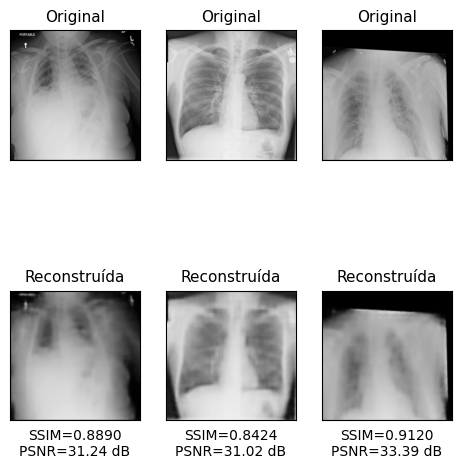

In [14]:
BASE_MODELS = "/content/drive/MyDrive/TCC/models"

plot_reconstrucoes_D3_api(
    ae_path=f"{BASE_MODELS}/AE_D3_autoencoder.keras",
    split="test",
    n=3,
    seed=42,
    channels=1
)
